# [LAB09] 지도학습 > 분류 > 07-다중분류(1)

종속변수의 값 종류가 3개 이상인 경우

## #01. 준비작업

### [1] 패키지 가져오기

In [19]:
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 분류모형 (대표모형 하나만 지정)
from sklearn.ensemble import RandomForestClassifier

# 로지스틱 성능평가 함수
from sklearn.metrics import (
    # log_loss,  # 다중분류 함수에서는 사용하지 않음
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")
from hs_eval_utils import *

### [2] 데이터 가져오기

붓꽃(iris)은 관상용으로도 재배되는 아름다운 꽃이며 크기와 색상이 다른 많은 종이 있다.

세 붓꽃 종의 이름은 Versicolor, Setosa, Virginica 이며 각 종에 따라 꽃받침의 길이와 너비, 꽃잎의 길이와 너비가 약간씩 차이가 난다.

> https://www.kaggle.com/datasets/uciml/iris

In [20]:
origin = load_data("iris")
origin.head()

1936년 영국의 통계학자 로널드 피셔(Ronald A. Fisher)가 소개한 3가지 품종(setosa, versicolor, virginica)의 붓꽃(Iris)에 대한 꽃받침과 꽃잎의 길이와 너비 측정값으로 구성된 유명한 머신러닝 및 데이터 분석용 데이터셋.(출처: Kaggle)

field         description
------------  -------------
Sepal.Length  꽃밭침 길이
Sepal.Width   꽃밭침 너비
Petal.Length  꽃잎 길이
Petal.Width   꽃잎 너비
Species       품종



,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


### [3] 데이터 기본 처리

#### 종속변수의 타입 변환

In [21]:
df1 = origin.copy()
df1["Species"] = df1["Species"].astype("category")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Sepal.Length  150 non-null    float64 
 1   Sepal.Width   150 non-null    float64 
 2   Petal.Length  150 non-null    float64 
 3   Petal.Width   150 non-null    float64 
 4   Species       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


#### 종속변수 종류 확인

In [22]:
df1["Species"].unique()

['setosa', 'versicolor', 'virginica']
Categories (3, object): ['setosa', 'versicolor', 'virginica']

#### 종속변수 라벨링

In [23]:
map_dict = {}
for i, v in enumerate(df1["Species"].unique()):
    map_dict[v] = i

map_dict

{'setosa': 0, 'versicolor': 1, 'virginica': 2}

In [24]:
df2 = df1.copy()
df2["Species"] = df2["Species"].map(map_dict)
df2["Species"].unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

### [4] 데이터 분할

In [25]:
yname = "Species"
x = df2.drop(columns=[yname])
y = df2[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

## #02. 분류모형 적합

### scoring에 적용할 수 있는 지표

#### 회귀모형

| scoring | 실무 핵심 | 의미 | 언제 사용 |
|---|---|---|---|
| r2 | ☆ | 모델이 데이터를 얼마나 설명하는지 나타내는 비율 | 기본 성능 비교 |
| neg_root_mean_squared_error | ☆ | 예측값과 실제값 차이의 평균적인 크기 | 가장 일반적인 회귀 평가 |
| neg_mean_absolute_error | ☆ | 오차의 절대값 평균 | 이상치 영향 줄이고 싶을 때 |
| neg_mean_absolute_percentage_error | ☆ | 실제값 대비 오차 비율 | 매출·가격처럼 비율 해석 필요할 때 |
| neg_mean_squared_log_error | | 로그 변환 후 오차 | 값의 범위 차이가 클 때 |
| neg_log_loss | | 확률 기반 예측의 정확성 | 확률 예측 회귀 모델 |
| neg_brier_score | | 확률 예측의 평균 오차 | 확률 보정 중요할 때 |

#### 분류모형

| scoring | 실무 핵심 | 의미 | 언제 사용 |
|---|---|---|---|
| accuracy | ☆ | 전체 중 맞춘 비율 | 클래스가 균형일 때 기본 평가 |
| balanced_accuracy | | 클래스별 정확도의 평균 | 클래스 불균형 존재 시 |
| precision | | 양성 예측 중 실제 양성 비율 | 오탐을 줄여야 할 때 |
| recall | | 실제 양성 중 맞춘 비율 | 놓치면 안 되는 문제 |
| f1 | ☆ | 정밀도와 재현율의 균형 점수 | 이항 분류 기본 지표 |
| f1_macro | ☆ | 각 클래스 F1의 단순 평균 | 다중분류 기본 권장 |
| f1_weighted | ☆ | 클래스 비율 반영 F1 평균 | 불균형 다중분류 |
| roc_auc | ☆ | 양성과 음성 구분 능력 | 이항 분류에서 확률 평가 |
| roc_auc_ovr | ☆ | 다중분류 확률 기반 구분 능력 | 다중분류 확률 모델 |
| average_precision | ☆ | 정밀도-재현율 기반 점수 | 심한 불균형 이항 분류 |

In [26]:
%%time

pipe = Pipeline([
    (
        "model",
        RandomForestClassifier(
            random_state=52,
            n_jobs=-1
        )
    ),
])

param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 1.0],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy", # <-- roc_auc를 사용할 수 없다.
    n_jobs=-1
)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: user 329 ms, sys: 130 ms, total: 459 ms
Wall time: 12.8 s


Pipeline(steps=[('model',
                 RandomForestClassifier(min_samples_leaf=5, n_estimators=300,
                                        n_jobs=-1, random_state=52))])

## #03. 성능평가지표

### [1] 기존의 성능평가 지표

| 평가지표 | 이항분류 | 다항분류 | 비고 |
|---|---|---|---|
| 정확도 (Accuracy) | ✅ | ✅ | 그대로 사용 가능 |
| 정밀도 (Precision) | ✅ | ✅ | 다항은 average 지정 필요 |
| 재현율 (Recall, TPR) | ✅ | ✅ | 다항은 average 지정 필요 |
| 위양성율 (FPR) | ✅ | ⚠️ | 다항은 OvR 방식으로만 가능 |
| 특이성 (TNR) | ✅ | ⚠️ | 다항은 OvR 방식 필요 |
| F1 Score | ✅ | ✅ | 다항은 average 지정 필요 |
| AUC | ✅ | ⚠️ | 다항은 roc_auc_ovr 또는 roc_auc_ovo 필요 |

### [2] 그대로 사용 가능한 성능평가 지표 도출

#### 입력값 정리

In [27]:
y_test = np.asarray(y_test).ravel()
y_pred = estimator.predict(x_test)
y_pred[:5]

array([0, 0, 2, 2, 2])

In [28]:
y_proba = estimator.predict_proba(x_test)
y_proba[:5]

array([[0.98431019, 0.01256524, 0.00312458],
       [1.        , 0.        , 0.        ],
       [0.        , 0.02674131, 0.97325869],
       [0.        , 0.02008126, 0.97991874],
       [0.        , 0.04178395, 0.95821605]])

In [29]:
classes = np.unique(y_test)
classes

array([0, 1, 2])

In [30]:
n_classes = len(classes)
n_classes

3

#### 정확도

전체 예측 중에서 올바르게 맞춘 비율

In [31]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9210526315789473

#### 정밀도

양성이라고 예측한 것 중 실제로 양성인 비율

In [32]:
precision = precision_score(
    y_test,
    y_pred,
    average="macro",  # 다중분류 문제에서 클래스별 지표의 단순 평균
    zero_division=0,  # 분모가 0이 되는 경우 오류 대신 해당 지표 값을 0으로 처리
)
precision

0.9473684210526315

#### 재현율

실제 양성 중에서 모델이 올바르게 찾아낸 비율

In [33]:
recall = recall_score(y_test, y_pred, average="macro", zero_division=0)
recall

0.923076923076923

#### f1 score

정밀도와 재현율을 균형 있게 종합한 성능 지표

In [34]:
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
f1

0.9279503105590061

## #04. 다항로지스틱에서 고려해야 하는 성능평가 지표

### [1] OvR (One vs Rest)

하나의 클래스를 "긍정적" 클래스로 간주하고 나머지 모든 클래스를 "부정적" 클래스로 간주하여 비교하는 방식

클래스가 K개라면 → K개의 이항 분류를 수행하는 구조

이를 통해 멀티클래스 분류를 이진 분류로 줄이므로 알려진 모든 이진 분류 측정 항목을 사용하여 이 시나리오를 평가할 수 있다

#### 클래스 종류 수 판별

In [35]:
# 예측값
y_pred = estimator.predict(x_test)
y_proba = estimator.predict_proba(x_test)
classes = estimator.classes_

fpr_list = []
tnr_list = []

print("=== 클래스별 OvR 결과 ===")
for i, cls in enumerate(classes):
    # 해당 클래스 vs 나머지
    y_true_binary = (y_test == cls).astype(int)
    y_pred_binary = (y_pred == cls).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    fpr = FP / (FP + TN) if (FP + TN) > 0 else np.nan
    tnr = TN / (FP + TN) if (FP + TN) > 0 else np.nan

    fpr_list.append(fpr)
    tnr_list.append(tnr)

    print(f"Class {cls}")
    print(f"  FPR: {fpr:.4f}")
    print(f"  TNR: {tnr:.4f}")
    print("-" * 30)

# -----------------------------
# 다중 AUC (OvR 방식)
# -----------------------------
auc_macro = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")

print("=== OvR Macro 평균 ===")
print(f"FPR (macro): {np.nanmean(fpr_list):.4f}")
print(f"TNR (macro): {np.nanmean(tnr_list):.4f}")
print(f"AUC (macro, OvR): {auc_macro:.4f}")

=== 클래스별 OvR 결과 ===
Class 0
  FPR: 0.0000
  TNR: 1.0000
------------------------------
Class 1
  FPR: 0.0000
  TNR: 1.0000
------------------------------
Class 2
  FPR: 0.1364
  TNR: 0.8636
------------------------------
=== OvR Macro 평균 ===
FPR (macro): 0.0455
TNR (macro): 0.9545
AUC (macro, OvR): 0.9961


#### 시각화

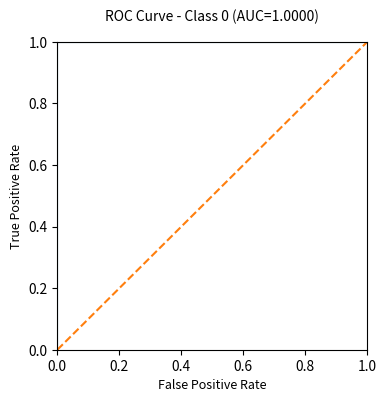

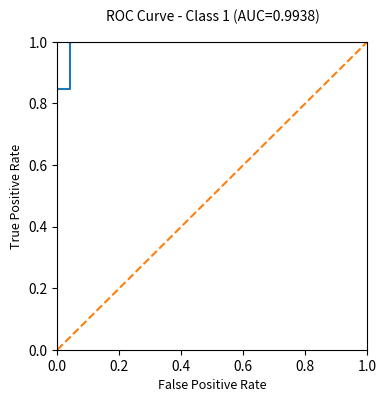

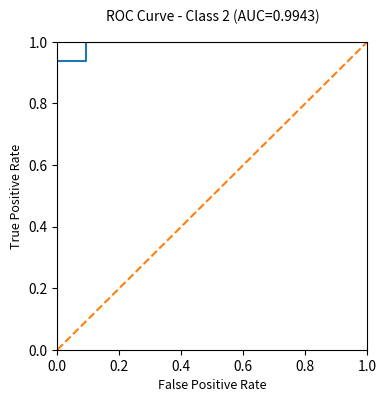

In [36]:
# 예측 확률
y_proba = estimator.predict_proba(x_test)
classes = estimator.classes_

# y_test 배열 정리
y_test_array = np.asarray(y_test).ravel()

for i, cls in enumerate(classes):
    # 해당 클래스 vs 나머지
    y_true_binary = (y_test_array == cls).astype(int)
    y_score = y_proba[:, i]

    # ROC 계산
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    auc_score = roc_auc_score(y_true_binary, y_score)

    # -----------------------------
    # 그래프 (클래스별 하나씩)
    # -----------------------------
    plt.figure(dpi=100, figsize=(4, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=9)
    plt.ylabel("True Positive Rate", fontsize=9)
    plt.title(f"ROC Curve - Class {cls} (AUC={auc_score:.4f})", fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

### [2] OvO (One vs One) - 거의 사용 안함

데이터 세트의 가능한 모든 클래스 조합을 비교하는 방식

3개의 클래스가 있을 때 `0 vs 1` 과 `1 vs 0` 은 서로 다르기 때문에 두 경우를 모두 고려해야 한다.

그러므로 IRIS 데이터 셋에는 총 6개의 OvO 점수를 얻는다.